In [15]:
%load_ext autoreload
%autoreload 1

# import segmentation_models_pytorch as smp
# from segmentation_models_pytorch.encoders import get_encoder

# from PIL import Image
import os
# from pathlib import Path
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

%aimport modules
from modules.DataScienceBowl import DataScienceBowl
from modules.Trainer import Trainer
from modules.CustomUnet import CustomUnet
from modules.Transforms import CombiTransform, ElasticTransform
from modules.denseCL import ProjectionModule, DenseContrastiveLoss, GlobalContrastiveLoss

from modules.denseCL.DenseCL import DenseCL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Set device to GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using cuda')
else:
    device = torch.device('cpu')
    print('using cpu')
    

# Set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

using cuda


In [10]:

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])

# Set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Load data and split into train and test
dataset = DataScienceBowl('data/data_science_train', transform=transform)

indices = torch.randperm(len(dataset)).tolist()
N = len(indices)
# [ 0.3 train | 0.1 test | 0.1 validate | 0.5 unlab ]
# train_test, test_val, val_unlab = map(int, (0.3 * N, 0.4 * N, 0.5 * N))


# [ 0.2 train | 0.05 test | 0.05 validate | 0.5 unlab ]
train_test, test_val, val_unlab = map(int, (0.2 * N, 0.25 * N, 0.3 * N))


train_dataset = torch.utils.data.Subset(dataset, indices[:train_test])
test_dataset = torch.utils.data.Subset(dataset, indices[train_test:test_val])
val_dataset = torch.utils.data.Subset(dataset, indices[test_val:val_unlab])
unlabeled_dataset = torch.utils.data.Subset(dataset, indices[val_unlab:])

print(len(unlabeled_dataset))

BATCH_SIZE = 8
dataLoader_training = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_test = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_unlabeled = DataLoader(dataset=unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_validation = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

469


In [21]:
MODEL_DIR = 'models/'
# models/DenseCL_GRID_{dense_head}_E-{epoch+1}_LR-{lr}_LAM-{lam}.pt
MODEL_NAME = 'DenseCL_GRID_%s_E-%s_LR-%s_LAM-%s.pt'

EPOCHS = list(map(str, range(5, 51, 5)))


hyper_parameters = {
    'lr': [0.01, 0.001, 0.0001],
    'lam': [0, 0.5, 1],
    'dense_head': ['5x5', '3x3'],
}



for lr in hyper_parameters['lr']:
    for lam in hyper_parameters['lam']:
        for dense_head in hyper_parameters['dense_head']:
            result_dict = dict()
            
            for e in EPOCHS:
                MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME %(dense_head, e, lr, lam))
                print(MODEL_PATH)
                
                contrastive_model = DenseCL()
                contrastive_model.load_state_dict(torch.load(MODEL_PATH))
#                 continue
                
                unet = CustomUnet(contrastive_model.encoder).to(device)

                criterion = torch.nn.BCEWithLogitsLoss()
                optimizer = torch.optim.SGD(unet.parameters(), lr=0.01, weight_decay=0.0001)

                trainer = Trainer(model=unet,
                                 device=device,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 training_DataLoader=dataLoader_training,
                                 validation_DataLoader=dataLoader_validation,
                                 test_DataLoader=dataLoader_test,
                                 epochs=20,
                                 notebook=True,
                                 seed=42)

                train_loss, val_loss, val_iou, test_loss, test_iou = trainer.run_trainer()

                result_dict[e] = {'train_loss': train_loss, 'val_loss': val_loss, 'val_iou':val_iou, 'test_loss':test_loss, 'test_iou':test_iou}
            
            test_iou_list = [item['test_iou'] for k, item in result_dict.items()]
            print(result_dict)
            print(f'lr:{lr} lam:{lam}, shape:{dense_head}', *test_iou_list)
            
            RESULT_PATH = os.path.join('results', MODEL_NAME %(dense_head, e, lr, lam) )
            with open(RESULT_PATH, 'wb') as file:
                pickle.dump(result_dict, file)
    

models/DenseCL_GRID_5x5_E-5_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8069707681150997, 0.5121365838191089, 0.38102445006370544, 0.34946681296124177, 0.3299783205284792, 0.2929808383478838, 0.26277706377646504, 0.2595729012699688, 0.23172113825293147, 0.22244000434875488, 0.22410115249016704, 0.20118792179752798, 0.20609275470761693, 0.18279349015039556, 0.18568147455944733, 0.18050875909188213, 0.17604944548186133, 0.168498191763373, 0.16778562086469986, 0.1593697982675889], 'val_loss': [0.5543442249298096, 0.43079707622528074, 0.3369839072227478, 0.307835590839386, 0.25819000601768494, 0.23563042879104615, 0.21408641040325166, 0.20512876510620118, 0.20739889442920684, 0.1750333771109581, 0.2032446086406708, 0.6008955672383308, 0.315261521935463, 0.16882625073194504, 0.15971097648143767, 0.20710453689098357, 0.14089478254318238, 0.1759317547082901, 0.15895471572875977, 0.15209246426820755], 'val_iou': [0.24241033186854483, 0.17422569265456725, 0.2132922112939291, 0.23469723145849622, 0.31542758266487764, 0.36354920979092087, 0.52

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.01_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.7912831271395964, 0.5077448504812577, 0.3771646250696743, 0.34572351329466877, 0.3261871811221628, 0.29265636380980997, 0.26035618782043457, 0.2620643377304077, 0.22958880136994755, 0.20907287737902472, 0.21924655402407928, 0.19836406497394338, 0.20445968210697174, 0.17792211911257574, 0.17979183091836817, 0.18069351858952465, 0.16964904481873794, 0.16300395481726704, 0.15556107198490815, 0.1513629717861905], 'val_loss': [0.517166155576706, 0.4446738600730896, 0.3397352993488312, 0.2785177111625671, 0.2692208528518677, 0.23441700637340546, 0.22719008922576905, 0.20372726321220397, 0.19746687710285188, 0.16790218353271485, 0.1952212333679199, 0.22142190337181092, 0.31664941906929017, 0.1635495737195015, 0.15566485077142717, 0.2499411880970001, 0.1465826988220215, 0.16514308154582977, 0.1494184046983719, 0.15569547712802886], 'val_iou': [0.2895429501160978, 0.21118142699377573, 0.1951789817581653, 0.25429458458279713, 0.324575574962243, 0.35978676469919324, 0.5188

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8342193645589492, 0.5172419793465558, 0.379262296592488, 0.3518042511799756, 0.3462098416160135, 0.2934533620581907, 0.26073961222873016, 0.26733515630750093, 0.22542115344720728, 0.2117039368433111, 0.2221875366042642, 0.2005695946076337, 0.21482232388328104, 0.18741223479018493, 0.19058419325772455, 0.19103088887298808, 0.17906490801011815, 0.17512571724022136, 0.16518020892844482, 0.16455539622727564], 'val_loss': [0.5625042080879211, 0.39622193574905396, 0.31773568987846373, 0.271632918715477, 0.2686851382255554, 0.23558999896049498, 0.20628753304481506, 0.21213037967681886, 0.20205858051776887, 0.16113374531269073, 0.23555346429347992, 0.20572211891412734, 0.3034950017929077, 0.17719865143299102, 0.1683315232396126, 0.21203384697437286, 0.15357548967003823, 0.1708780601620674, 0.16513250917196273, 0.17169518917798995], 'val_iou': [0.1664894896495596, 0.20669039198156494, 0.32287831449399335, 0.3395299071760476, 0.34012063979500057, 0.3788400355867865, 0.482

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.01_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.7967190812615788, 0.47731354131418113, 0.3568600398652694, 0.3278910447569454, 0.3238253803814159, 0.27303371797589693, 0.24678754806518555, 0.2510508728377959, 0.21764966056627386, 0.20410784728386822, 0.2156841491951662, 0.1966532267191831, 0.2035807265954859, 0.18194068442372716, 0.1823913349824793, 0.1820064283469144, 0.17600942841347525, 0.17335403316161213, 0.16424918437705321, 0.1617882225443335], 'val_loss': [0.5182004749774933, 0.4006450533866882, 0.3142932176589966, 0.3094384253025055, 0.28699918687343595, 0.23406148850917816, 0.20739019215106963, 0.2121538758277893, 0.20753903985023497, 0.15761427879333495, 0.21192438006401063, 0.27980747520923616, 0.38713130354881287, 0.2031609147787094, 0.16789640486240387, 0.20963955521583558, 0.1473317563533783, 0.2658083915710449, 0.15464727729558944, 0.22786348760128022], 'val_iou': [0.22791628932884164, 0.2018763395990324, 0.28696065914728464, 0.2918478755607109, 0.25566818366535504, 0.3591285515289357, 0.47778

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.84228796117446, 0.5096165344995611, 0.3965897402342628, 0.3690696306088391, 0.35244500286438885, 0.31168416493079243, 0.27914112105089073, 0.27902581586557273, 0.2458591671550975, 0.22896480472648845, 0.23173071706996246, 0.21710945578182445, 0.21979492639794068, 0.20053947497816646, 0.19680500731748693, 0.19648445616750157, 0.189355970305555, 0.1811728530070361, 0.17380915231564464, 0.17247550540110645], 'val_loss': [0.5465740084648132, 0.4287126898765564, 0.36299884915351865, 0.3209827423095703, 0.31804790496826174, 0.2768090546131134, 0.2394618034362793, 0.23748867809772492, 0.23762851655483247, 0.18590085208415985, 0.24994706809520723, 0.22943007051944733, 0.3009982109069824, 0.19402567446231841, 0.184161177277565, 0.25700094997882844, 0.15311564058065413, 0.19898884296417235, 0.162804214656353, 0.17984684258699418], 'val_iou': [0.1671205774252146, 0.12338957774902086, 0.15901217818932356, 0.17066689930400375, 0.1354014583847275, 0.205323834598477, 0.3572940

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.01_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8020227235906264, 0.4983982706771177, 0.3670859757591696, 0.32906129605629864, 0.3218555625747232, 0.27431683329974904, 0.24465580635211048, 0.24678231425145092, 0.21709546271492453, 0.2033016927102033, 0.21519076385918787, 0.19623039662837982, 0.20196639264331145, 0.18430446351275726, 0.1852997190812055, 0.18646573494462407, 0.17958445014322505, 0.1728868265362347, 0.16734167714329326, 0.16278836832327], 'val_loss': [0.4995099663734436, 0.43076621294021605, 0.3250302791595459, 0.28620912730693815, 0.27585073113441466, 0.23515550196170806, 0.20999930202960967, 0.209307399392128, 0.2078986257314682, 0.16060799807310105, 0.24585985243320466, 0.3476463779807091, 0.33140464425086974, 0.19444998651742934, 0.17234794199466705, 0.26872284710407257, 0.1494130939245224, 0.23285581469535827, 0.16480826884508132, 0.21223237961530686], 'val_iou': [0.2599842770967429, 0.29130257232981926, 0.3704870184371256, 0.40382707055149697, 0.41128805709703026, 0.4384919858607127, 0.502

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.7852850906989154, 0.48896290449535146, 0.38069865107536316, 0.34606021993300495, 0.32960742361405315, 0.29364676861202016, 0.25840629374279694, 0.2520507959758534, 0.21481292125056772, 0.20231044993681066, 0.20417947541264928, 0.1873289662248948, 0.18538287983221166, 0.16589457147261677, 0.16335174616645365, 0.17000650395365322, 0.16563277866910486, 0.15469611962051952, 0.15126753773759394, 0.1406507886507932], 'val_loss': [0.5060274422168731, 0.3896582365036011, 0.3284547507762909, 0.3031660944223404, 0.3043502390384674, 0.25482381582260133, 0.2094112068414688, 0.21075305342674255, 0.19284535050392151, 0.15962025225162507, 0.20491318106651307, 0.34781244248151777, 0.44420923590660094, 0.16799651980400085, 0.14165785610675813, 0.29180141985416413, 0.13415270298719406, 0.18236970901489258, 0.13205933272838594, 0.13987334966659545], 'val_iou': [0.24816782269780918, 0.22673373059128532, 0.23189395918438943, 0.26886980206791555, 0.23824928568455395, 0.36667074187218

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8330630905487958, 0.545512961990693, 0.41632624233470245, 0.37400952156852274, 0.34812865011832295, 0.3098818773732466, 0.27116718625321107, 0.2683505976901335, 0.2253475934267044, 0.21129660658976612, 0.21989383767632878, 0.2013856128734701, 0.21281035595080433, 0.18350778081837824, 0.1737339058343102, 0.17035208204213312, 0.16808253176072063, 0.15582779006046407, 0.15247121803900776, 0.15222247777616277], 'val_loss': [0.5694457292556763, 0.4673761367797852, 0.3919252634048462, 0.3152393102645874, 0.3854736268520355, 0.2820640057325363, 0.22613119781017305, 0.20357975065708162, 0.19862092435359954, 0.16456356197595595, 0.3044674307107925, 0.3224667266011238, 0.6906959712505341, 0.20517580807209015, 0.15290710031986238, 0.2649476811289787, 0.12856023386120796, 0.16250730603933333, 0.14713125973939895, 0.1378829747438431], 'val_iou': [0.14439391026404866, 0.18295003214279668, 0.18333912780425682, 0.1873394866860828, 0.13736160606279582, 0.23656863639597056, 0.411

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8069205143872429, 0.5418577036436867, 0.4121195796658011, 0.36877744513399463, 0.34017419990371256, 0.29116641423281503, 0.24842173211714802, 0.255630785928053, 0.21580132842063904, 0.1932707393870634, 0.20643074284581578, 0.18451071749715245, 0.19420107322580674, 0.16533395472694845, 0.16279937326908112, 0.1611611124347238, 0.16187531632535598, 0.15316574012531953, 0.14423824671436758, 0.1424266516285784], 'val_loss': [0.5422532975673675, 0.46139383912086485, 0.3654516816139221, 0.31291011571884153, 0.32099569439888, 0.23670453429222107, 0.20173498392105102, 0.2062578469514847, 0.183163645863533, 0.15272179394960403, 0.21594480872154237, 0.5906072288751603, 0.4034733384847641, 0.15708670616149903, 0.1420450046658516, 0.16525293439626693, 0.12202459871768952, 0.13619664311408997, 0.12968679517507553, 0.13272628039121628], 'val_iou': [0.30933675584054104, 0.2867602537607948, 0.3180976217045628, 0.3181823379748324, 0.2877159815986755, 0.4582501950478405, 0.5490633

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.7840950243613299, 0.4967141659820781, 0.3853343216811909, 0.3581811557797825, 0.33130751111928153, 0.2899714822278303, 0.258586263831924, 0.2642659588771708, 0.22774322769221136, 0.20882241252590628, 0.21640470098046696, 0.19414455662755406, 0.19526864062337315, 0.1793409147683312, 0.1775068973793703, 0.1672418599619585, 0.17061487979748668, 0.1572660391821581, 0.157431964050321, 0.14865858721382477], 'val_loss': [0.5978543639183045, 0.39921032190322875, 0.3528536677360535, 0.28293581306934357, 0.32556821703910827, 0.24037352502346038, 0.2167021781206131, 0.274546816945076, 0.22198857963085175, 0.16594554632902145, 0.2157369524240494, 0.27212604880332947, 0.342554035782814, 0.15508745461702347, 0.15952765494585036, 0.18949915766716002, 0.13681363239884375, 0.19056712388992308, 0.17704131454229355, 0.2071837916970253], 'val_iou': [0.2527878479585127, 0.25494630400052704, 0.2536805018182611, 0.35284261523152355, 0.22296406919695527, 0.4148695847495875, 0.478077468

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8136175905956942, 0.5277045965194702, 0.3918343028601478, 0.3577578120371875, 0.3400379454388338, 0.2901732702465618, 0.2553565379451303, 0.2561500677291085, 0.2213584096992717, 0.20092470768619985, 0.2088775468223235, 0.1878542382927502, 0.1905901651172077, 0.17065716753987706, 0.16799697192276225, 0.16545023287043853, 0.16749257901135614, 0.16085209390696356, 0.15089087626513312, 0.1468051693895284], 'val_loss': [0.5742804408073425, 0.4605683147907257, 0.3559284210205078, 0.30352939665317535, 0.28967795968055726, 0.2538091778755188, 0.21983686983585357, 0.2124743103981018, 0.20654865503311157, 0.16796476691961287, 0.20074439346790313, 0.2573875322937965, 0.3956473857164383, 0.1562880277633667, 0.15246600210666655, 0.20064789056777954, 0.1452455773949623, 0.17318907380104065, 0.14726153016090393, 0.1513276070356369], 'val_iou': [0.18637929324389613, 0.20676900639208268, 0.20948933327007002, 0.2595321721153197, 0.22437837899195964, 0.31334504688352227, 0.5485931

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.822596904109506, 0.5132896181415109, 0.3852173160104191, 0.3528657888664919, 0.34169773669803843, 0.2894675398574156, 0.2572914870346294, 0.2567983769318637, 0.22223223658169017, 0.20428327514844782, 0.22142305794884176, 0.19903378276263967, 0.1985815167427063, 0.17936615470577688, 0.17455328124410965, 0.1740800151053597, 0.16810921711080215, 0.16169102489948273, 0.15465747959473553, 0.15439110030146205], 'val_loss': [0.5478549897670746, 0.41935165524482726, 0.34198988080024717, 0.31976284086704254, 0.293279704451561, 0.25255458652973173, 0.21410212218761443, 0.21151424646377565, 0.20830745995044708, 0.16585329174995422, 0.2360984593629837, 0.21827917844057082, 0.3261242151260376, 0.17909131050109864, 0.16164444535970687, 0.1946253851056099, 0.14249349683523177, 0.18476761877536774, 0.1567470446228981, 0.15156165957450868], 'val_iou': [0.18093401450968277, 0.15087143871679592, 0.24692773290986972, 0.2829502287841486, 0.20019263505135373, 0.3212322624688263, 0.48

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8064981944420758, 0.527611725470599, 0.40538254380226135, 0.3697405369842754, 0.3368753001970403, 0.30390844187315774, 0.26981305462472577, 0.26487265176632824, 0.23455287603770986, 0.2122601998202941, 0.21962882841334624, 0.19827183993423686, 0.1979361982906566, 0.17393670800854177, 0.16990197669057286, 0.1703588357743095, 0.1619027002769358, 0.15511677370351903, 0.15326910071513233, 0.14623751140692653], 'val_loss': [0.5483945667743683, 0.44429128170013427, 0.38323734402656556, 0.37494024634361267, 0.3747156262397766, 0.2479502648115158, 0.216982963681221, 0.20945310294628144, 0.21257294416427613, 0.17353567630052566, 0.2131047159433365, 0.3762457832694054, 0.3601710945367813, 0.15744562298059464, 0.16099086701869963, 0.32698031663894656, 0.15210895985364914, 0.1517513081431389, 0.14938217252492905, 0.15776756405830383], 'val_iou': [0.3168095650433824, 0.17351809927829748, 0.17757750912521622, 0.1404828671855234, 0.17245383047994517, 0.25186058728794697, 0.437

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.0001_LAM-0.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8212153210359461, 0.5382935141815859, 0.42509397689033956, 0.3958729996400721, 0.3721637848545523, 0.3258814128006206, 0.2859725312275045, 0.2821642221773372, 0.2341221255414626, 0.2234995926127714, 0.22894370380569906, 0.1983778879922979, 0.21046281211516438, 0.1853672493906582, 0.1766987144947052, 0.17913629202281728, 0.17790890748009963, 0.1618075993131189, 0.16946122400900898, 0.1593719804111649], 'val_loss': [0.5762267291545868, 0.4557380676269531, 0.38046315908432005, 0.30943776071071627, 0.6375776469707489, 0.2898829519748688, 0.23221343457698823, 0.22329824268817902, 0.21659397184848786, 0.17535959035158158, 0.2299852639436722, 0.4342607229948044, 0.5319183558225632, 0.17171355187892914, 0.15944418162107468, 0.30091687440872195, 0.13520603030920028, 0.16767390668392182, 0.15175266861915587, 0.16079316884279252], 'val_iou': [0.1728115071641883, 0.14635496629545436, 0.14050764460500662, 0.1437504331182084, 0.09956269707666865, 0.1586081151770284, 0.3801073

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8033978027455947, 0.5223879288224613, 0.3948650114676532, 0.35547605682821837, 0.337026108713711, 0.3014996227096109, 0.25486573489273295, 0.24618429646772497, 0.21222424244179444, 0.19768675460534937, 0.20718185515964732, 0.18662358469822826, 0.18497419094338136, 0.16621535753502564, 0.16270653991138234, 0.15825066321036396, 0.15947125720627167, 0.15056900022660985, 0.14340268338427825, 0.13922771680004456], 'val_loss': [0.5457858264446258, 0.4721364200115204, 0.35496246814727783, 0.3021587014198303, 0.486561119556427, 0.24791359305381774, 0.20405634939670564, 0.19649770557880403, 0.19473180770874024, 0.15534171611070632, 0.19786901772022247, 0.3984066680073738, 0.2533249169588089, 0.13922931551933287, 0.13465642631053926, 0.16041883677244187, 0.12001668512821198, 0.21306538879871367, 0.13209151178598405, 0.14430297911167145], 'val_iou': [0.2234015877884103, 0.20075766705510056, 0.2017647302270266, 0.20607485685285046, 0.15898717606275964, 0.24547414049755895, 

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.0001_LAM-0.5.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8131237871506635, 0.5074482752996332, 0.38660645484924316, 0.35911890689064474, 0.34494776059599486, 0.30962005082298727, 0.2765727840802249, 0.27350471563198986, 0.24024390034815846, 0.2187662238583845, 0.23072061994496515, 0.20920206781695871, 0.20886834404047797, 0.1868789239841349, 0.18326430198024302, 0.17915940021767335, 0.18153702160891363, 0.16778372578761158, 0.15889292166513555, 0.1612793356180191], 'val_loss': [0.5752731919288635, 0.39701531529426576, 0.3603861331939697, 0.3030430763959885, 0.31739264726638794, 0.26165019571781156, 0.24236199855804444, 0.20978799760341643, 0.2026429921388626, 0.17005673348903655, 0.2042348116636276, 0.2657063603401184, 0.36389411985874176, 0.1620313972234726, 0.15253821462392808, 0.2139218807220459, 0.140192611515522, 0.15811624079942704, 0.14385464489459993, 0.19133757203817367], 'val_iou': [0.21557633684929933, 0.1808950555980557, 0.17978605293748584, 0.16904427410872433, 0.14352603447670942, 0.2003613362405016, 0.3

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-10_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-15_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-20_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-25_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-30_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-35_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-40_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-45_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_5x5_E-50_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.8195897340774536, 0.525494363378076, 0.39243192006559935, 0.36056803079212413, 0.3413088251562679, 0.3010948063696132, 0.26701569031266603, 0.2635899852303898, 0.2259361857877058, 0.20643345398061416, 0.21207580759244807, 0.19710778839447918, 0.1958061149891685, 0.17990932569784276, 0.17282421185689814, 0.1693489341174855, 0.165699963183964, 0.15548469301532297, 0.1521510998992359, 0.14487005156629226], 'val_loss': [0.5640748620033265, 0.49045326709747317, 0.32862576842308044, 0.35363003313541413, 0.3614142119884491, 0.24523455798625945, 0.21976323127746583, 0.22123515009880065, 0.20676229596138002, 0.16043992340564728, 0.2103324592113495, 0.25866377651691436, 0.38209348320961, 0.15614626109600066, 0.16710571944713593, 0.23894488513469697, 0.13240893930196762, 0.14067666381597518, 0.133555306494236, 0.16152312606573105], 'val_iou': [0.27146238113461446, 0.22741687634164887, 0.26763733996663586, 0.2585924927438863, 0.15636589078691585, 0.32536919942356474, 0.4920

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-10_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-15_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-20_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-25_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-30_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-35_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-40_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-45_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

models/DenseCL_GRID_3x3_E-50_LR-0.0001_LAM-1.pt
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

{'5': {'train_loss': [0.7797050651381997, 0.49001672688652487, 0.3659720596145181, 0.3427659588701585, 0.3256730226909413, 0.28307483038481546, 0.2412813051658518, 0.2433490349965937, 0.2089699419105754, 0.1919658394420848, 0.19981079154154835, 0.1868951184784665, 0.1925906530197929, 0.16279090415028966, 0.16121340499204748, 0.16358565802083297, 0.16066061047946706, 0.15468394449528525, 0.14896009292672663, 0.14449072979828892], 'val_loss': [0.5332919418811798, 0.40335174202919005, 0.3158935308456421, 0.31691152453422544, 0.34650508165359495, 0.2240591049194336, 0.17107052505016326, 0.1769958570599556, 0.18929779529571533, 0.14376589953899382, 0.19940575063228608, 0.43291939198970797, 0.39897972345352173, 0.14794551134109496, 0.13271233588457107, 0.20755302906036377, 0.12505440190434455, 0.1716638058423996, 0.12931186705827713, 0.16306019723415374], 'val_iou': [0.28231633999626854, 0.2732707339898698, 0.3376953531184287, 0.3513081777082757, 0.3812254367058946, 0.42071276378489647, 0.66

<ipython-input-44-3567de26d68e>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


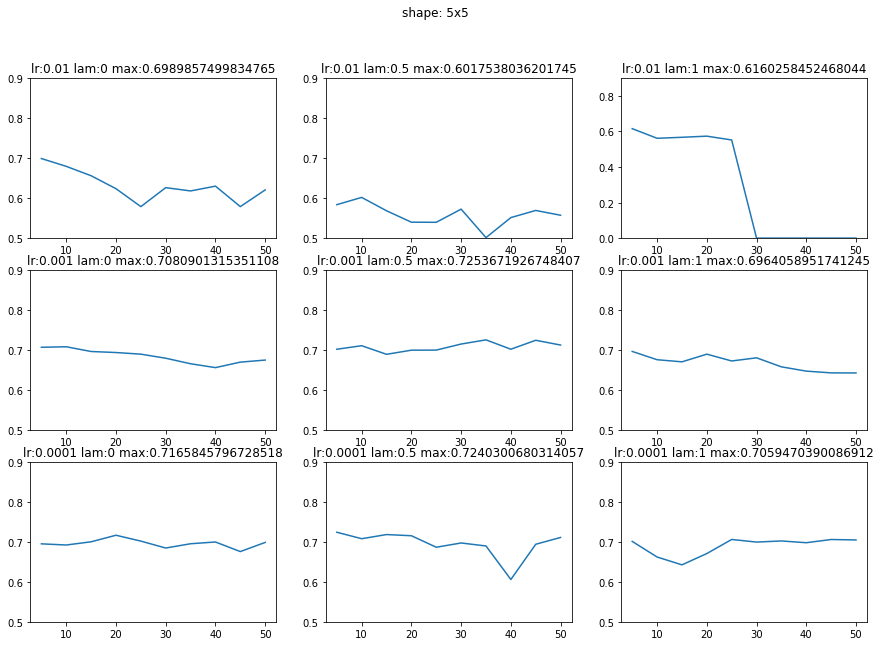

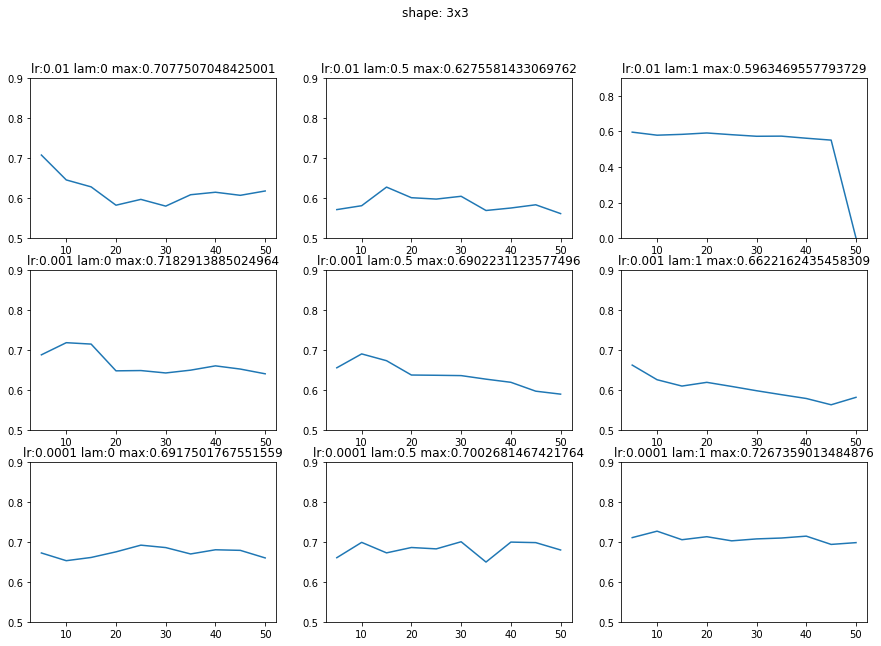

In [44]:
MODEL_DIR = 'models/'
# models/DenseCL_GRID_{dense_head}_E-{epoch+1}_LR-{lr}_LAM-{lam}.pt
MODEL_NAME = 'DenseCL_GRID_%s_E-%s_LR-%s_LAM-%s.pt'

EPOCHS = list(map(str, range(5, 51, 5)))


hyper_parameters = {
    'lr': [0.01, 0.001, 0.0001],
    'lam': [0, 0.5, 1],
    'dense_head': ['5x5', '3x3'],
}


for dense_head in hyper_parameters['dense_head']:
    
    fig, ax = plt.subplots(3, 3, figsize=(15,10))
    fig.suptitle(f'shape: {dense_head}')
    
    
    for i, lr in enumerate(hyper_parameters['lr']):
        for j, lam in enumerate(hyper_parameters['lam']):
        
            
            RESULT_PATH = os.path.join('results', MODEL_NAME %(dense_head, e, lr, lam) )
#             print(RESULT_PATH)
#             print(f'Load model with params -> lr:{lr} lam:{lam}, shape:{dense_head}')
            with open(RESULT_PATH, 'rb') as file:            
                result_dict = pickle.load(file)
                
            test_ious = list()
            x_axis = range(5,51,5)
            
            for e, results in result_dict.items():
                test_ious.append(results['test_iou'])
                
            
                
            ax[i,j].plot(x_axis, test_ious)
            ax[i,j].set_ylim(min(0.5, min(test_ious)), 0.9)
            ax[i,j].set_title(f'lr:{lr} lam:{lam} max:{max(test_ious)}')
            
    
    fig.show()
            
                    
#             for e, results in result_dict.items():
#                 print('Test IoU', np.round(results['test_iou'], 4))
#                 plt.plot(results['train_loss'])
#                 plt.plot(results['val_loss'])
#                 plt.hlines(results['test_loss'], 0, len(results['train_loss']) - 1, color='red')
#                 plt.show()
    

In [26]:
results_dict = {'5': {'train_loss': [0.8069707681150997, 0.5121365838191089, 0.38102445006370544, 0.34946681296124177, 0.3299783205284792, 0.2929808383478838, 0.26277706377646504, 0.2595729012699688, 0.23172113825293147, 0.22244000434875488, 0.22410115249016704, 0.20118792179752798, 0.20609275470761693, 0.18279349015039556, 0.18568147455944733, 0.18050875909188213, 0.17604944548186133, 0.168498191763373, 0.16778562086469986, 0.1593697982675889], 'val_loss': [0.5543442249298096, 0.43079707622528074, 0.3369839072227478, 0.307835590839386, 0.25819000601768494, 0.23563042879104615, 0.21408641040325166, 0.20512876510620118, 0.20739889442920684, 0.1750333771109581, 0.2032446086406708, 0.6008955672383308, 0.315261521935463, 0.16882625073194504, 0.15971097648143767, 0.20710453689098357, 0.14089478254318238, 0.1759317547082901, 0.15895471572875977, 0.15209246426820755], 'val_iou': [0.24241033186854483, 0.17422569265456725, 0.2132922112939291, 0.23469723145849622, 0.31542758266487764, 0.36354920979092087, 0.5243701016285633, 0.5626084012536399, 0.5543203379022439, 0.5924683461952859, 0.5835587316869252, 0.4763635646383192, 0.5833938278058313, 0.6451664570244239, 0.6732633266944659, 0.628688549654607, 0.6625064012126415, 0.6125418329620008, 0.6802179396024396, 0.6062244332232201], 'test_loss': 0.14468963891267778, 'test_iou': 0.6989857499834765}, '10': {'train_loss': [0.8045515943976009, 0.4984360249603496, 0.3778979936066796, 0.35076819272602305, 0.3397320245995241, 0.30046023253132315, 0.27763212516027336, 0.2716954990344889, 0.24106460371438196, 0.22291856127626755, 0.2283141201033312, 0.20477774739265442, 0.20916890747406902, 0.18791552939835718, 0.18934446573257446, 0.18804565510329077, 0.1777525487191537, 0.1733603223281748, 0.1647951585405013, 0.15736076498732848], 'val_loss': [0.5578698575496673, 0.4168303430080414, 0.3546251058578491, 0.3054259866476059, 0.27945904433727264, 0.24521137475967408, 0.21559222638607026, 0.2096419155597687, 0.21583875715732576, 0.1714790493249893, 0.2168748825788498, 0.19995346516370774, 0.27923540472984315, 0.16580899208784103, 0.17584315836429595, 0.1857464700937271, 0.1570604644715786, 0.21461358070373535, 0.15391699969768524, 0.16327691972255706], 'val_iou': [0.2037795341629473, 0.20501222806690184, 0.18120965092408162, 0.2121247814071955, 0.23433782700965478, 0.31775525244483527, 0.4657740502549504, 0.5004065839237375, 0.5004235870161948, 0.5725490433478138, 0.5501541158901005, 0.5620537238014155, 0.572294694965872, 0.6247527803128128, 0.623172563364151, 0.6253130828502632, 0.6112283549736939, 0.5322371539193733, 0.6743853441958172, 0.5863435223265198], 'test_loss': 0.1517104610800743, 'test_iou': 0.679444080168898}, '15': {'train_loss': [0.8000393334557029, 0.48836451067644004, 0.3680954715784858, 0.3374316972844741, 0.318185311906478, 0.2815837570849587, 0.25599032552803264, 0.25447667346281166, 0.2265773643465603, 0.20987464487552643, 0.2139429204604205, 0.19757945222013137, 0.20357070424977472, 0.18405074494726517, 0.1834545126732658, 0.18426991999149323, 0.17829171874943903, 0.17217783542240367, 0.16489755669060877, 0.1601733262924587], 'val_loss': [0.5564165949821472, 0.4035747587680817, 0.3298546075820923, 0.3087774246931076, 0.26159034967422484, 0.23385898172855377, 0.20870427489280702, 0.20616392493247987, 0.21179551482200623, 0.16805591732263564, 0.21093668341636657, 0.20839522927999496, 0.26815112829208376, 0.17410313636064528, 0.1770516574382782, 0.21060613095760344, 0.14438694566488267, 0.22922352850437164, 0.2203935980796814, 0.1802925333380699], 'val_iou': [0.25288456777458157, 0.22603125833871446, 0.25233666685482037, 0.322173590294202, 0.39731153677923886, 0.447074284947535, 0.5226660597616802, 0.5286132909372532, 0.5146536681261301, 0.5883495973885703, 0.5437262436093563, 0.5658382868711832, 0.5660642756848538, 0.5999189512979123, 0.6121204539393739, 0.5813966019038068, 0.618593054110139, 0.5065081786558195, 0.5645423628727608, 0.5657072250676851], 'test_loss': 0.16572991609573365, 'test_iou': 0.655970470944751}, '20': {'train_loss': [0.7881873600623187, 0.4800274442223942, 0.3609112711513744, 0.3315872304579791, 0.3158230588716619, 0.2757811178179348, 0.2513626498334548, 0.25333624902893515, 0.2244772420209997, 0.2104683684952119, 0.21639126977499792, 0.19891779387698455, 0.20477616261033452, 0.18545266547623804, 0.18802464446600745, 0.18400818986051223, 0.17847401341971228, 0.1726483281920938, 0.1638868148712551, 0.1612649051582112], 'val_loss': [0.5221686899662018, 0.3947557032108307, 0.3256747484207153, 0.3107407927513123, 0.27292373180389407, 0.23452524244785308, 0.21016420423984528, 0.20817736089229583, 0.20819215178489686, 0.17278867065906525, 0.22258026599884034, 0.2243825763463974, 0.3042506158351898, 0.1949399247765541, 0.17824304103851318, 0.20930318683385848, 0.15483379140496253, 0.1930704668164253, 0.16201965510845184, 0.17902357429265975], 'val_iou': [0.2718543410011793, 0.23278214769824818, 0.266752018439926, 0.3038174126023672, 0.4054672031625605, 0.4089280115143514, 0.4860427405462815, 0.5065354212381641, 0.5060364531881963, 0.5687063490292534, 0.5068534657399865, 0.48851917900015474, 0.4930283637252634, 0.5310449394562629, 0.5963362362551988, 0.5512389835108535, 0.5825469845012824, 0.5614401002934722, 0.6344324825805929, 0.5503720783133471], 'test_loss': 0.17547301352024078, 'test_iou': 0.6235255159502883}, '25': {'train_loss': [0.7865700301002053, 0.4774952793822569, 0.3540056891301099, 0.3271258245496189, 0.3181077636340085, 0.27306482283508077, 0.2494003010146758, 0.25074200069203095, 0.22353385301197276, 0.20836371183395386, 0.21568184740403118, 0.19799825286164002, 0.2057325550738503, 0.18441996942548192, 0.18467172980308533, 0.18443801034899318, 0.17854018465561025, 0.17350009171401753, 0.16177871998618631, 0.1604249705286587], 'val_loss': [0.5211560606956482, 0.39725797176361083, 0.3206541836261749, 0.29630365073680875, 0.2898993670940399, 0.23586432933807372, 0.2075703889131546, 0.20630196630954742, 0.21036600470542907, 0.1693161979317665, 0.225565767288208, 0.2304246947169304, 0.3234027951955795, 0.1890045240521431, 0.17553493678569793, 0.21809778213500977, 0.15541848093271254, 0.21128767728805542, 0.1621724024415016, 0.18618700206279754], 'val_iou': [0.2548622506659275, 0.24226798181551668, 0.30733252527951965, 0.35594242349053823, 0.4597872887062099, 0.39998762498464774, 0.48172169459827535, 0.5211193277215879, 0.49402849271540444, 0.565712970716352, 0.4852909708998939, 0.4598360784277826, 0.43984174043336866, 0.5245308054582138, 0.5916244881717997, 0.5269695081882441, 0.5778467584869388, 0.5115450685671733, 0.6288071987523394, 0.5120757377303597], 'test_loss': 0.19060790538787842, 'test_iou': 0.5787479002098197}, '30': {'train_loss': [0.7872238755226135, 0.4777546034139745, 0.35678647195591645, 0.32854701841578765, 0.3178544026963851, 0.27480176967733044, 0.25101493912584644, 0.2523688875577029, 0.22366593953441172, 0.21066711930667653, 0.21693367730168736, 0.19782416697810679, 0.20438034306554234, 0.18563542997135835, 0.18536271856111639, 0.18534078405183904, 0.18107293414718964, 0.17600668703808503, 0.16619136929512024, 0.16345550777281032], 'val_loss': [0.5181877374649048, 0.39660200476646423, 0.3218497335910797, 0.2954621434211731, 0.29491143226623534, 0.2356225222349167, 0.213060262799263, 0.2091498553752899, 0.21109564006328582, 0.16981580555438996, 0.2306360274553299, 0.23708261400461197, 0.3638062685728073, 0.187304225564003, 0.17286901772022248, 0.21456593573093413, 0.1508635997772217, 0.18830012977123262, 0.16032254546880723, 0.17625586539506913], 'val_iou': [0.2619505558259873, 0.2783815562572754, 0.31744656381043285, 0.385681123295737, 0.4696491230101959, 0.4298999870775866, 0.48756459172211847, 0.5029006786960319, 0.48917104032550646, 0.5645836300375445, 0.4850717111221366, 0.4660032675651361, 0.4164743827607914, 0.5654075399243462, 0.5917856629580858, 0.5407587754452927, 0.5900485826803834, 0.5651002742594994, 0.6381171511979955, 0.5470996943156246], 'test_loss': 0.16931820213794707, 'test_iou': 0.6261648903781322}, '35': {'train_loss': [0.7862439856809729, 0.47855516216334176, 0.35769694692948284, 0.3315589743502, 0.31819668499862447, 0.2754516461316277, 0.25273652637706084, 0.2518467780421762, 0.22568320965065675, 0.2118046537918203, 0.21697003262884476, 0.19941988412071676, 0.20436968347605536, 0.1853584059897591, 0.185295309214031, 0.18356067205176635, 0.18038400919998393, 0.17472062216085546, 0.16485120093121247, 0.16294936353669448], 'val_loss': [0.5293005466461181, 0.3914268732070923, 0.3210037529468536, 0.28980126678943635, 0.30698715448379515, 0.23312670290470122, 0.21544622182846068, 0.20801337957382202, 0.21564751267433166, 0.17284560203552246, 0.23013662099838256, 0.2288693219423294, 0.34088410139083863, 0.19755949676036835, 0.18085057139396668, 0.22618625164031983, 0.1525057502090931, 0.18338332921266556, 0.16469027996063232, 0.1824002742767334], 'val_iou': [0.24367202830929363, 0.2719020213158812, 0.32857800628242373, 0.39098571472910987, 0.45714356938837375, 0.42532026980452364, 0.4766932994289128, 0.49883463611851286, 0.46802148740312066, 0.5504113703032518, 0.4713831866569135, 0.486609173825177, 0.45373763570904097, 0.5209757155252338, 0.5681126744226542, 0.5263672277955076, 0.5791348566019002, 0.5602279929772893, 0.6251546347676078, 0.5255120441338934], 'test_loss': 0.17532760500907899, 'test_iou': 0.617959202398544}, '40': {'train_loss': [0.7843519694664899, 0.4745343257399166, 0.354000820833094, 0.3288743478410384, 0.3174522676888634, 0.275563293520142, 0.2501552499392453, 0.2512357611866558, 0.2226224769564236, 0.21014266943230347, 0.21444078578668482, 0.19756661618457122, 0.20176674863871405, 0.18440554685452404, 0.18268824763157787, 0.18391498835647807, 0.17935428023338318, 0.1734218089019551, 0.16350829294499228, 0.16209588287507787], 'val_loss': [0.5083161771297455, 0.3846959829330444, 0.3172682523727417, 0.28604854345321656, 0.3012139439582825, 0.22713167667388917, 0.21019668281078338, 0.2056887447834015, 0.21138932108879088, 0.17065729051828385, 0.2290511965751648, 0.23099102675914765, 0.3168588519096375, 0.17808733582496644, 0.17527600824832917, 0.218047633767128, 0.14857980087399483, 0.18582309484481813, 0.15901975482702255, 0.18329898566007613], 'val_iou': [0.25144477740993965, 0.2941258194684771, 0.3420507123705281, 0.4135804890681121, 0.48291448946308824, 0.4433151922750561, 0.487243081826594, 0.5096563338910783, 0.4720144483445571, 0.5596880579826212, 0.4749365088386245, 0.48714163347567796, 0.49033122938561996, 0.5550077209900812, 0.582289198501677, 0.5303235960788915, 0.5864877479764975, 0.5579247409122239, 0.6375365682128828, 0.5308130203589433], 'test_loss': 0.16771111786365508, 'test_iou': 0.6299440515423106}, '45': {'train_loss': [0.7864958678974825, 0.4713098704814911, 0.349487758734647, 0.32668859818402457, 0.318571372943766, 0.27363136498367086, 0.25153689962976117, 0.25272136137766, 0.22433733501855066, 0.21100912549916437, 0.21474321800119736, 0.2006334522191216, 0.20558759920737324, 0.18632342096637278, 0.18440002027679891, 0.18630639507490046, 0.17873966913012898, 0.17328031711718617, 0.16541054494240703, 0.1627319599775707], 'val_loss': [0.4997078776359558, 0.3772239863872528, 0.31050589084625246, 0.2909502863883972, 0.2796852231025696, 0.2319788545370102, 0.21256462335586548, 0.20677530765533447, 0.21264398396015166, 0.17057495266199113, 0.2325773388147354, 0.2443881079554558, 0.30798029005527494, 0.19188917726278304, 0.1812740981578827, 0.22400673627853393, 0.15244051367044448, 0.23178152441978456, 0.16203537881374358, 0.21138633787631989], 'val_iou': [0.2550842289425631, 0.2934457310327852, 0.32047438120114513, 0.3968244400352162, 0.44119200693361843, 0.41588600064055453, 0.4777882553768141, 0.5083291173419106, 0.4689172314298192, 0.551881163969281, 0.4685821412796537, 0.46469267188824076, 0.4734298049152589, 0.5568728928271951, 0.5668129009360332, 0.5182472635014841, 0.5719327837214249, 0.4807959991811052, 0.6320157921607581, 0.47748930394804445], 'test_loss': 0.1960832506418228, 'test_iou': 0.578748439170752}, '50': {'train_loss': [0.791181389023276, 0.47747324494754567, 0.3582297212937299, 0.33461181907092824, 0.3214594914632685, 0.27474255859851837, 0.254086715333602, 0.255557301289895, 0.22644811956321492, 0.21230919483829946, 0.21721402424223282, 0.2006968890919405, 0.20637709866551793, 0.18730019383570728, 0.18930700158371644, 0.18753117059960084, 0.1834010008503409, 0.17595971594838536, 0.16583732471746557, 0.1626361718072611], 'val_loss': [0.522110003232956, 0.3904123425483704, 0.3357841670513153, 0.2997059941291809, 0.2768133759498596, 0.24764952361583709, 0.22001345157623292, 0.21833915412425994, 0.2153511941432953, 0.17964655458927153, 0.23412106931209564, 0.2028089702129364, 0.2905548483133316, 0.1938741534948349, 0.1752797245979309, 0.22064118683338166, 0.1518849514424801, 0.23126738518476486, 0.16839522868394852, 0.1852345272898674], 'val_iou': [0.24217137347484624, 0.2555701495203172, 0.27487755663091756, 0.3241172896737498, 0.3626954799612913, 0.40071155848963, 0.4792000302804751, 0.507418331310942, 0.48199047360156666, 0.546958768508371, 0.4613173926029859, 0.5155400494427053, 0.5022100086133129, 0.5323367405005968, 0.5960092728993243, 0.5452683668260281, 0.5949156209088493, 0.4822905867285871, 0.6253605562782442, 0.529266796535377], 'test_loss': 0.17322975546121597, 'test_iou': 0.6204905006732856}}
with open("results/DenseCL_GRID_5x5_E-50_LR-0.01_LAM-0.pt", 'wb') as file:
    pickle.dump(results_dict, file)

Test IoU 0.2478


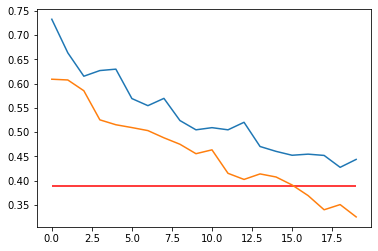

Test IoU 0.5054


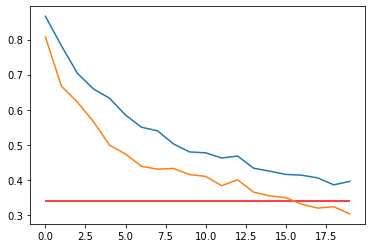

Test IoU 0.4823


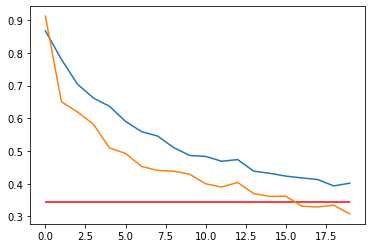

Test IoU 0.4471


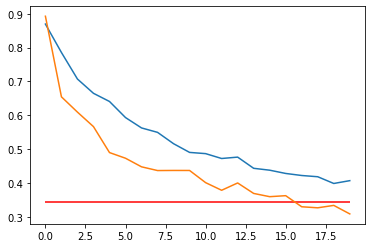

Test IoU 0.4444


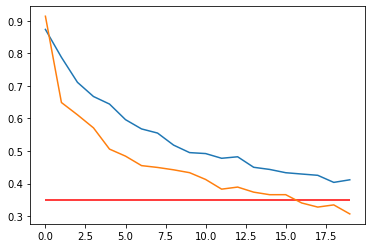

Test IoU 0.4618


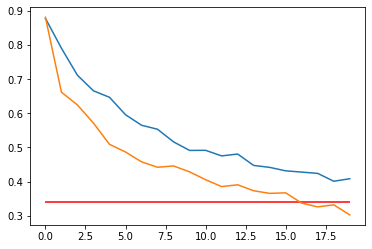

Test IoU 0.4668


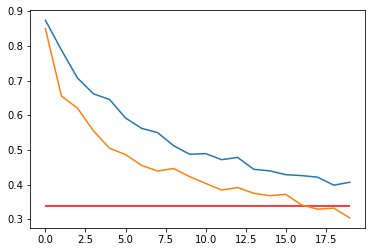

Test IoU 0.4498


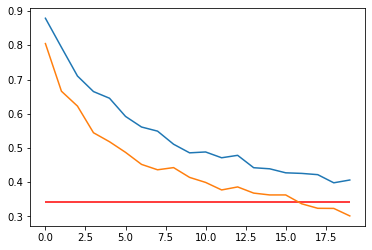

Test IoU 0.4406


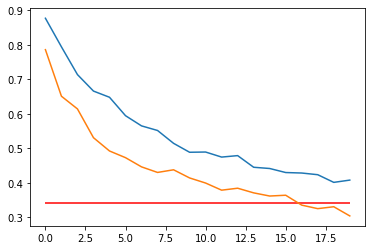

Test IoU 0.4307


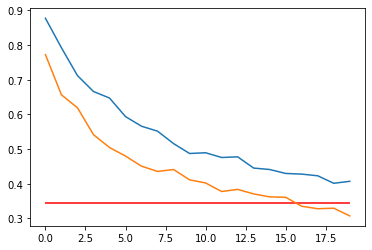

In [8]:
for e, results in result_dict.items():
    print('Test IoU', np.round(results['test_iou'], 4))
    plt.plot(results['train_loss'])
    plt.plot(results['val_loss'])
    plt.hlines(results['test_loss'], 0, len(results['train_loss']) - 1, color='red')
    plt.show()

In [21]:
import pickle


with open('results_lr0_01_analysis.pk', 'wb') as file:
    pickle.dump(result_dict, file)